In [1]:
import numpy as np
import pandas as pd
import torch 
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
###look for this
from torchvision import transforms as T, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
pd.options.plotting.backend = "plotly"

In [2]:
data_dir = "../input/chest-xray-pneumonia/chest_xray/"
TEST = 'test'
TRAIN = 'train'
VAL = 'val'

In [3]:
def data_transform(phase = None):
    if phase == TRAIN:
        data_T = T.Compose([
            T.Resize(size = (256,256)),
            T.RandomRotation(degrees = (-20,20)),
            T.CenterCrop(size = 224),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    elif phase == TEST or phase == VAL:
        data_T = T.Compose([
            T.Resize(size = (224,224)), 
            T.ToTensor(), 
            T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    return data_T

In [4]:
trainset = datasets.ImageFolder(os.path.join(data_dir+TRAIN), transform = data_transform(TRAIN))

testset = datasets.ImageFolder(os.path.join(data_dir+TEST), transform = data_transform(TEST))

validset = datasets.ImageFolder(os.path.join(data_dir+VAL), transform = data_transform(VAL))



In [5]:
class_name = trainset.classes
print(class_name)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [6]:
def get_class_count(dataset):
    class_name = dataset.classes
    classes = []
    for _,labels in tqdm(dataset):
        classes.append(class_name[labels])
    return classes

100%|██████████| 5216/5216 [02:31<00:00, 34.34it/s]


Text(0.5, 1.0, 'Train_set')

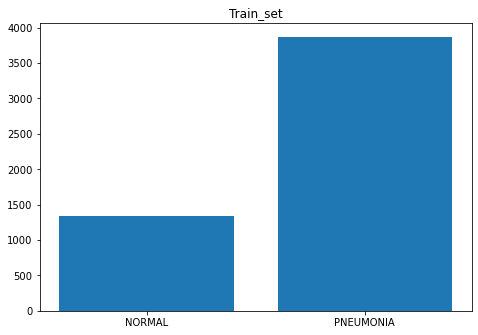

In [7]:
count = get_class_count(trainset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("Train_set")

100%|██████████| 624/624 [00:14<00:00, 42.11it/s]


Text(0.5, 1.0, 'Test_set')

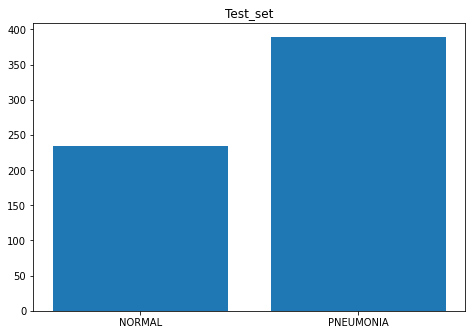

In [8]:
count = get_class_count(testset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("Test_set")

100%|██████████| 16/16 [00:00<00:00, 43.15it/s]


Text(0.5, 1.0, 'valid_set')

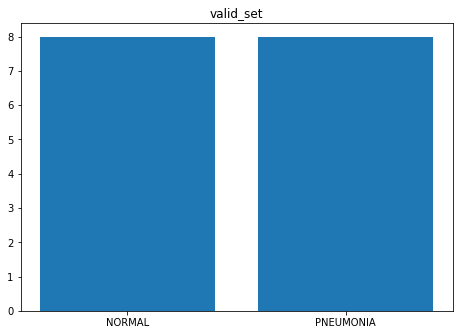

In [9]:
count = get_class_count(validset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("valid_set")

In [10]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)
validloader = DataLoader(validset,batch_size = 8,shuffle = False)
testloader = DataLoader(testset,batch_size = 8,shuffle = False)

Lets look into the images!

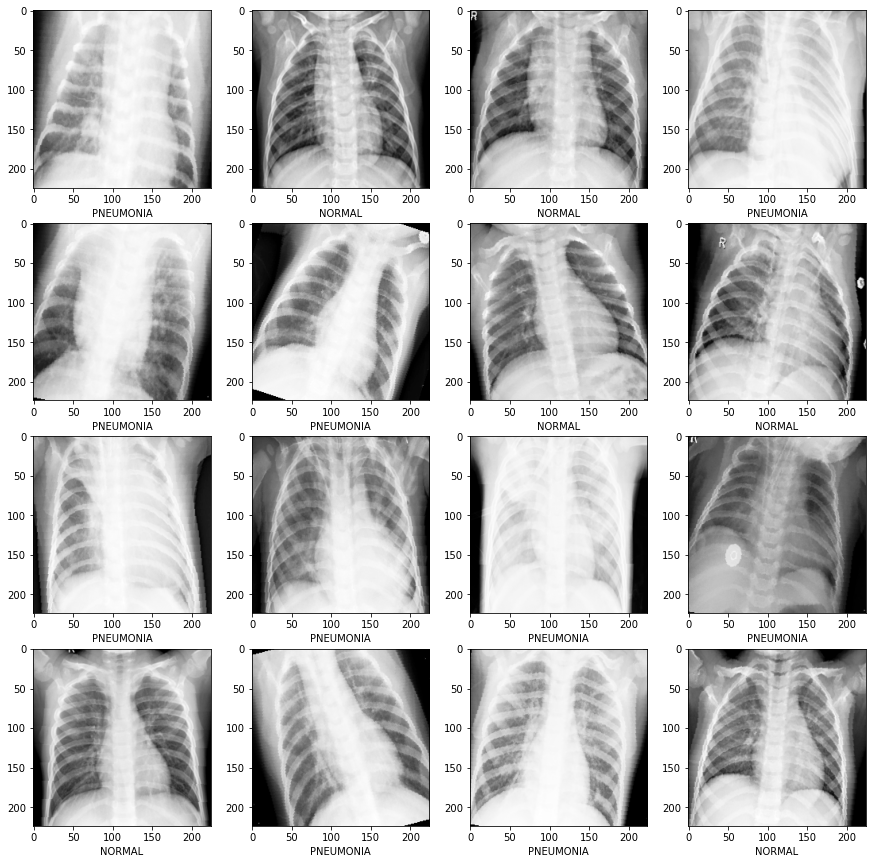

In [11]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
plt.figure(figsize = (15,15))
for i in range(0,images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i][0].numpy().squeeze(),cmap = 'Greys_r')
    plt.xlabel(class_name[labels[i].item()])

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
#Load pretrained Model
resnet50 = models.resnet50(pretrained=True)

In [25]:
resnet50.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [26]:
#Not Freezing model parameters
for param in resnet50.parameters():
    param.require_grad = True
    

In [27]:
model = resnet50
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 30
valid_loss_min = np.Inf


In [29]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


In [30]:
train_loss_list = []
valid_loss_list = []

train_acc_list = []
valid_acc_list = []


for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(trainloader)
    avg_train_loss = train_loss / len(trainloader)
    
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(validloader)
        avg_valid_loss = valid_loss / len(validloader)
        
        valid_loss_list.append(avg_valid_loss)
        valid_acc_list.append(avg_valid_acc)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'Pneumonia_model.pt')
            
            valid_loss_min = avg_valid_loss
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Validation loss decreased (inf --> 0.366684).   Saving model ...


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 1 Train Loss : 0.241230 Train Acc : 0.906633
Epoch : 1 Valid Loss : 0.366684 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.165511 Train Acc : 0.937692
Epoch : 2 Valid Loss : 0.657733 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.167095 Train Acc : 0.936158
Epoch : 3 Valid Loss : 0.928972 Valid Acc : 0.625000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.139420 Train Acc : 0.954371
Epoch : 4 Valid Loss : 0.778004 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.143693 Train Acc : 0.945744
Epoch : 5 Valid Loss : 0.752434 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.126272 Train Acc : 0.954179
Epoch : 6 Valid Loss : 1.039252 Valid Acc : 0.625000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.136140 Train Acc : 0.952454
Epoch : 7 Valid Loss : 0.669084 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.101169 Train Acc : 0.961656
Epoch : 8 Valid Loss : 0.588128 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.083363 Train Acc : 0.969709
Epoch : 9 Valid Loss : 0.741367 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.079443 Train Acc : 0.972201
Epoch : 10 Valid Loss : 0.555960 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.073003 Train Acc : 0.975077
Epoch : 11 Valid Loss : 0.493288 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.080256 Train Acc : 0.972393
Epoch : 12 Valid Loss : 0.601366 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.058934 Train Acc : 0.979294
Epoch : 13 Valid Loss : 0.864390 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.061615 Train Acc : 0.977377
Epoch : 14 Valid Loss : 0.912711 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.055465 Train Acc : 0.980253
Epoch : 15 Valid Loss : 0.791423 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.057024 Train Acc : 0.978336
Epoch : 16 Valid Loss : 0.633967 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.048418 Train Acc : 0.981979
Epoch : 17 Valid Loss : 0.680973 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.048803 Train Acc : 0.981020
Epoch : 18 Valid Loss : 0.727785 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.055955 Train Acc : 0.979678
Epoch : 19 Valid Loss : 0.764691 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.050413 Train Acc : 0.981787
Epoch : 20 Valid Loss : 0.674770 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.060617 Train Acc : 0.981020
Epoch : 21 Valid Loss : 0.701168 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.050696 Train Acc : 0.982554
Epoch : 22 Valid Loss : 0.708975 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.054609 Train Acc : 0.981979
Epoch : 23 Valid Loss : 0.617682 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.054785 Train Acc : 0.982745
Epoch : 24 Valid Loss : 0.799483 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.058163 Train Acc : 0.978528
Epoch : 25 Valid Loss : 0.698411 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 26 Train Loss : 0.052398 Train Acc : 0.981403
Epoch : 26 Valid Loss : 0.766073 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 27 Train Loss : 0.058731 Train Acc : 0.980253
Epoch : 27 Valid Loss : 0.642937 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 28 Train Loss : 0.052095 Train Acc : 0.980828
Epoch : 28 Valid Loss : 0.667929 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch : 29 Train Loss : 0.055235 Train Acc : 0.981787
Epoch : 29 Valid Loss : 0.668935 Valid Acc : 0.812500


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

Epoch : 30 Train Loss : 0.057555 Train Acc : 0.980253
Epoch : 30 Valid Loss : 0.729680 Valid Acc : 0.750000


In [31]:
model.eval()

test_loss = 0
test_acc = 0

for images,labels in testloader:
    
    images = images.to(device)
    labels = labels.to(device)
    
    pred = model(images)
    loss = criterion(pred,labels)
    
    test_loss += loss.item()
    test_acc += accuracy(pred,labels)
    
avg_test_loss = test_loss/len(testloader)
avg_test_acc = test_acc/len(testloader)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(avg_test_loss,avg_test_acc))

Test Loss : 0.347830 Test Acc : 0.913462


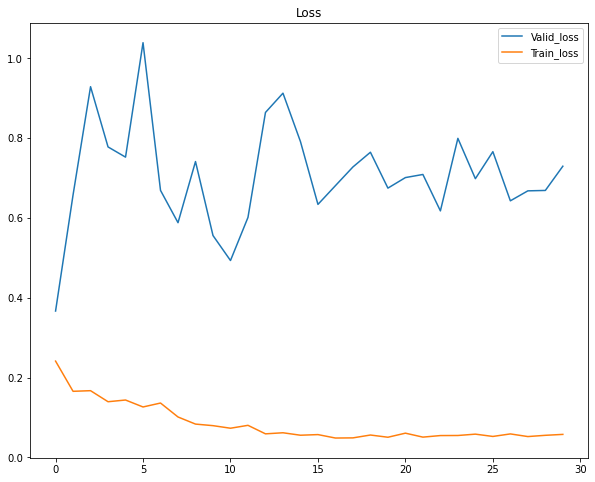

In [32]:
plt.figure(figsize = (10,8))
plt.title("Loss")
plt.plot(valid_loss_list, label='Valid_loss')
plt.plot(train_loss_list, label='Train_loss')
# plt.style.use('seaborn-darkgrid')
plt.legend()


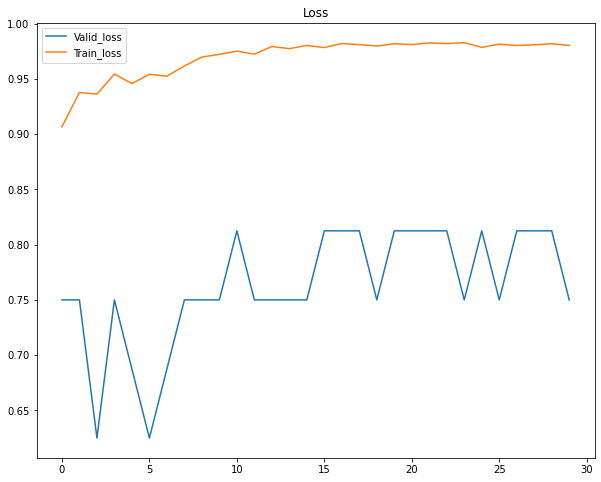

In [33]:
plt.figure(figsize = (10,8))
plt.title("Loss")
plt.plot(valid_acc_list, label='Valid_loss')
plt.plot(train_acc_list, label='Train_loss')
# plt.style.use('seaborn-darkgrid')
plt.legend()


### Class Activation Mapping

In [35]:
!pip install pytorch-gradcam


     |████████████████████████████████| 6.0 MB 4.2 MB/s eta 0:00:01
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=b952752d9d1ea53cbc7afb516914c41521a476116b47057477de0e942457ae8c
  Stored in directory: /root/.cache/pip/wheels/06/e7/da/b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [49]:
from PIL import Image, ImageOps
from gradcam.utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

In [41]:
test_transform = T.Compose([
            T.Resize(size = (224,224)), 
            T.ToTensor(), 
            T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

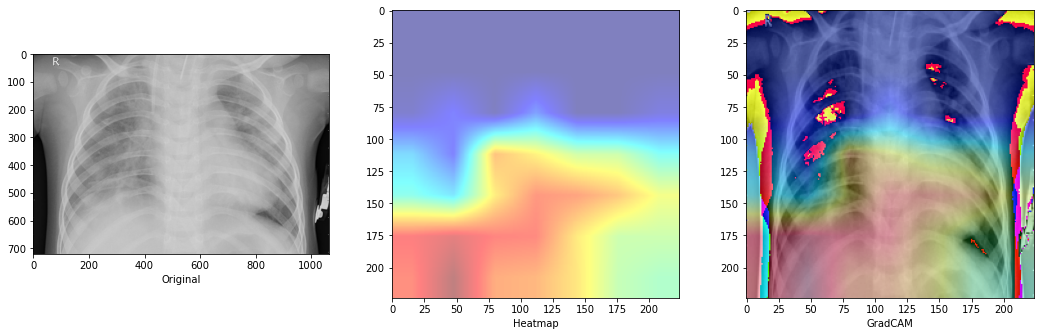

In [55]:
pil_img = Image.open("../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_483.jpeg")
pil_img = pil_img.convert('RGB')
normed_torch_img = test_transform(pil_img).unsqueeze(0).cuda()
resnet = model
resnet.eval()
resnet.cuda()
gradcam = GradCAMpp.from_config(model_type='resnet',
                              arch=resnet, layer_name='layer4')
mask, logit = gradcam(normed_torch_img, class_idx=1)
heatmap, cam_result = visualize_cam(mask, normed_torch_img)
a = T.ToPILImage()

heatmap, cam_result = visualize_cam(mask, normed_torch_img)

a = T.ToPILImage()

img1 = a(heatmap)
img2 = a(cam_result)
plt.figure(1,figsize=(18,18))
plt.subplot(331)
plt.xlabel('Original')
plt.imshow(pil_img)
plt.subplot(332)
plt.xlabel('Heatmap')
plt.imshow(img1,cmap='jet', alpha = 0.5)
plt.subplot(333)
plt.xlabel('GradCAM')
plt.imshow(img2,cmap='jet')

# print(predict(model,"./image7 (2).jpeg_180.jpg"))

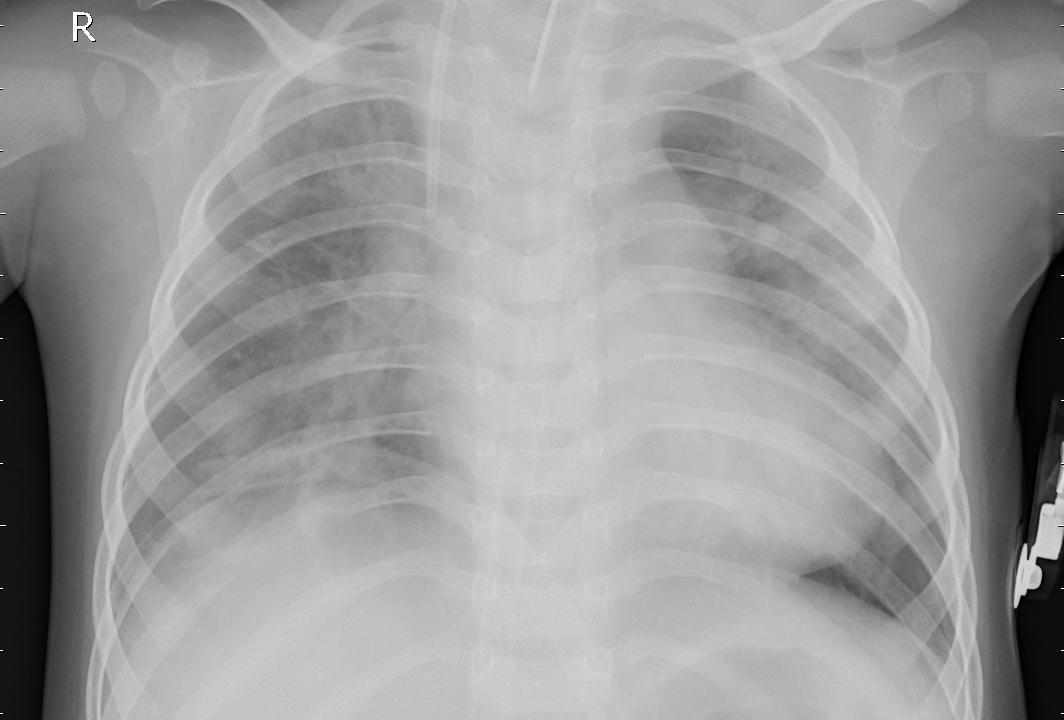

In [51]:
pil_img = Image.open("../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_481.jpeg")
pil_img = pil_img.convert('RGB')
normed_torch_img = test_transform(pil_img).unsqueeze(0).cuda()
resnet = model
resnet.eval()
resnet.cuda()
gradcam = GradCAMpp.from_config(model_type='resnet',
                              arch=resnet, layer_name='layer4')
mask, logit = gradcam(normed_torch_img, class_idx=1)
heatmap, cam_result = visualize_cam(mask, normed_torch_img)
a = T.ToPILImage()

heatmap, cam_result = visualize_cam(mask, normed_torch_img)

a = T.ToPILImage()

img1 = a(heatmap)
img2 = a(cam_result)
plt.figure(1,figsize=(14,14))
plt.subplot(331)
plt.xlabel('Original')
plt.imshow(pil_img)
plt.subplot(332)
plt.xlabel('Heatmap')
plt.imshow(img1,cmap='jet', alpha = 0.5)
plt.subplot(333)
plt.xlabel('GradCAM')
plt.imshow(img2,cmap='jet')

# print(predict(model,"./image7 (2).jpeg_180.jpg"))